In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from skimage import exposure

from tensorflow.keras.datasets import cifar10
from tensorflow.data import Dataset

In [2]:
sns.set(rc={'figure.dpi': 120})
sns.set_style('whitegrid')

## Exploratory Data Analysis

In [3]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

In [4]:
print(f'Train image shape: {train_images.shape}')
print(f'Test image shape: {test_images.shape}')

Train image shape: (50000, 32, 32, 3)
Test image shape: (10000, 32, 32, 3)


In [5]:
n_labels = len(np.unique(train_labels))
print(f'Number of labels: {n_labels}')

Number of labels: 10


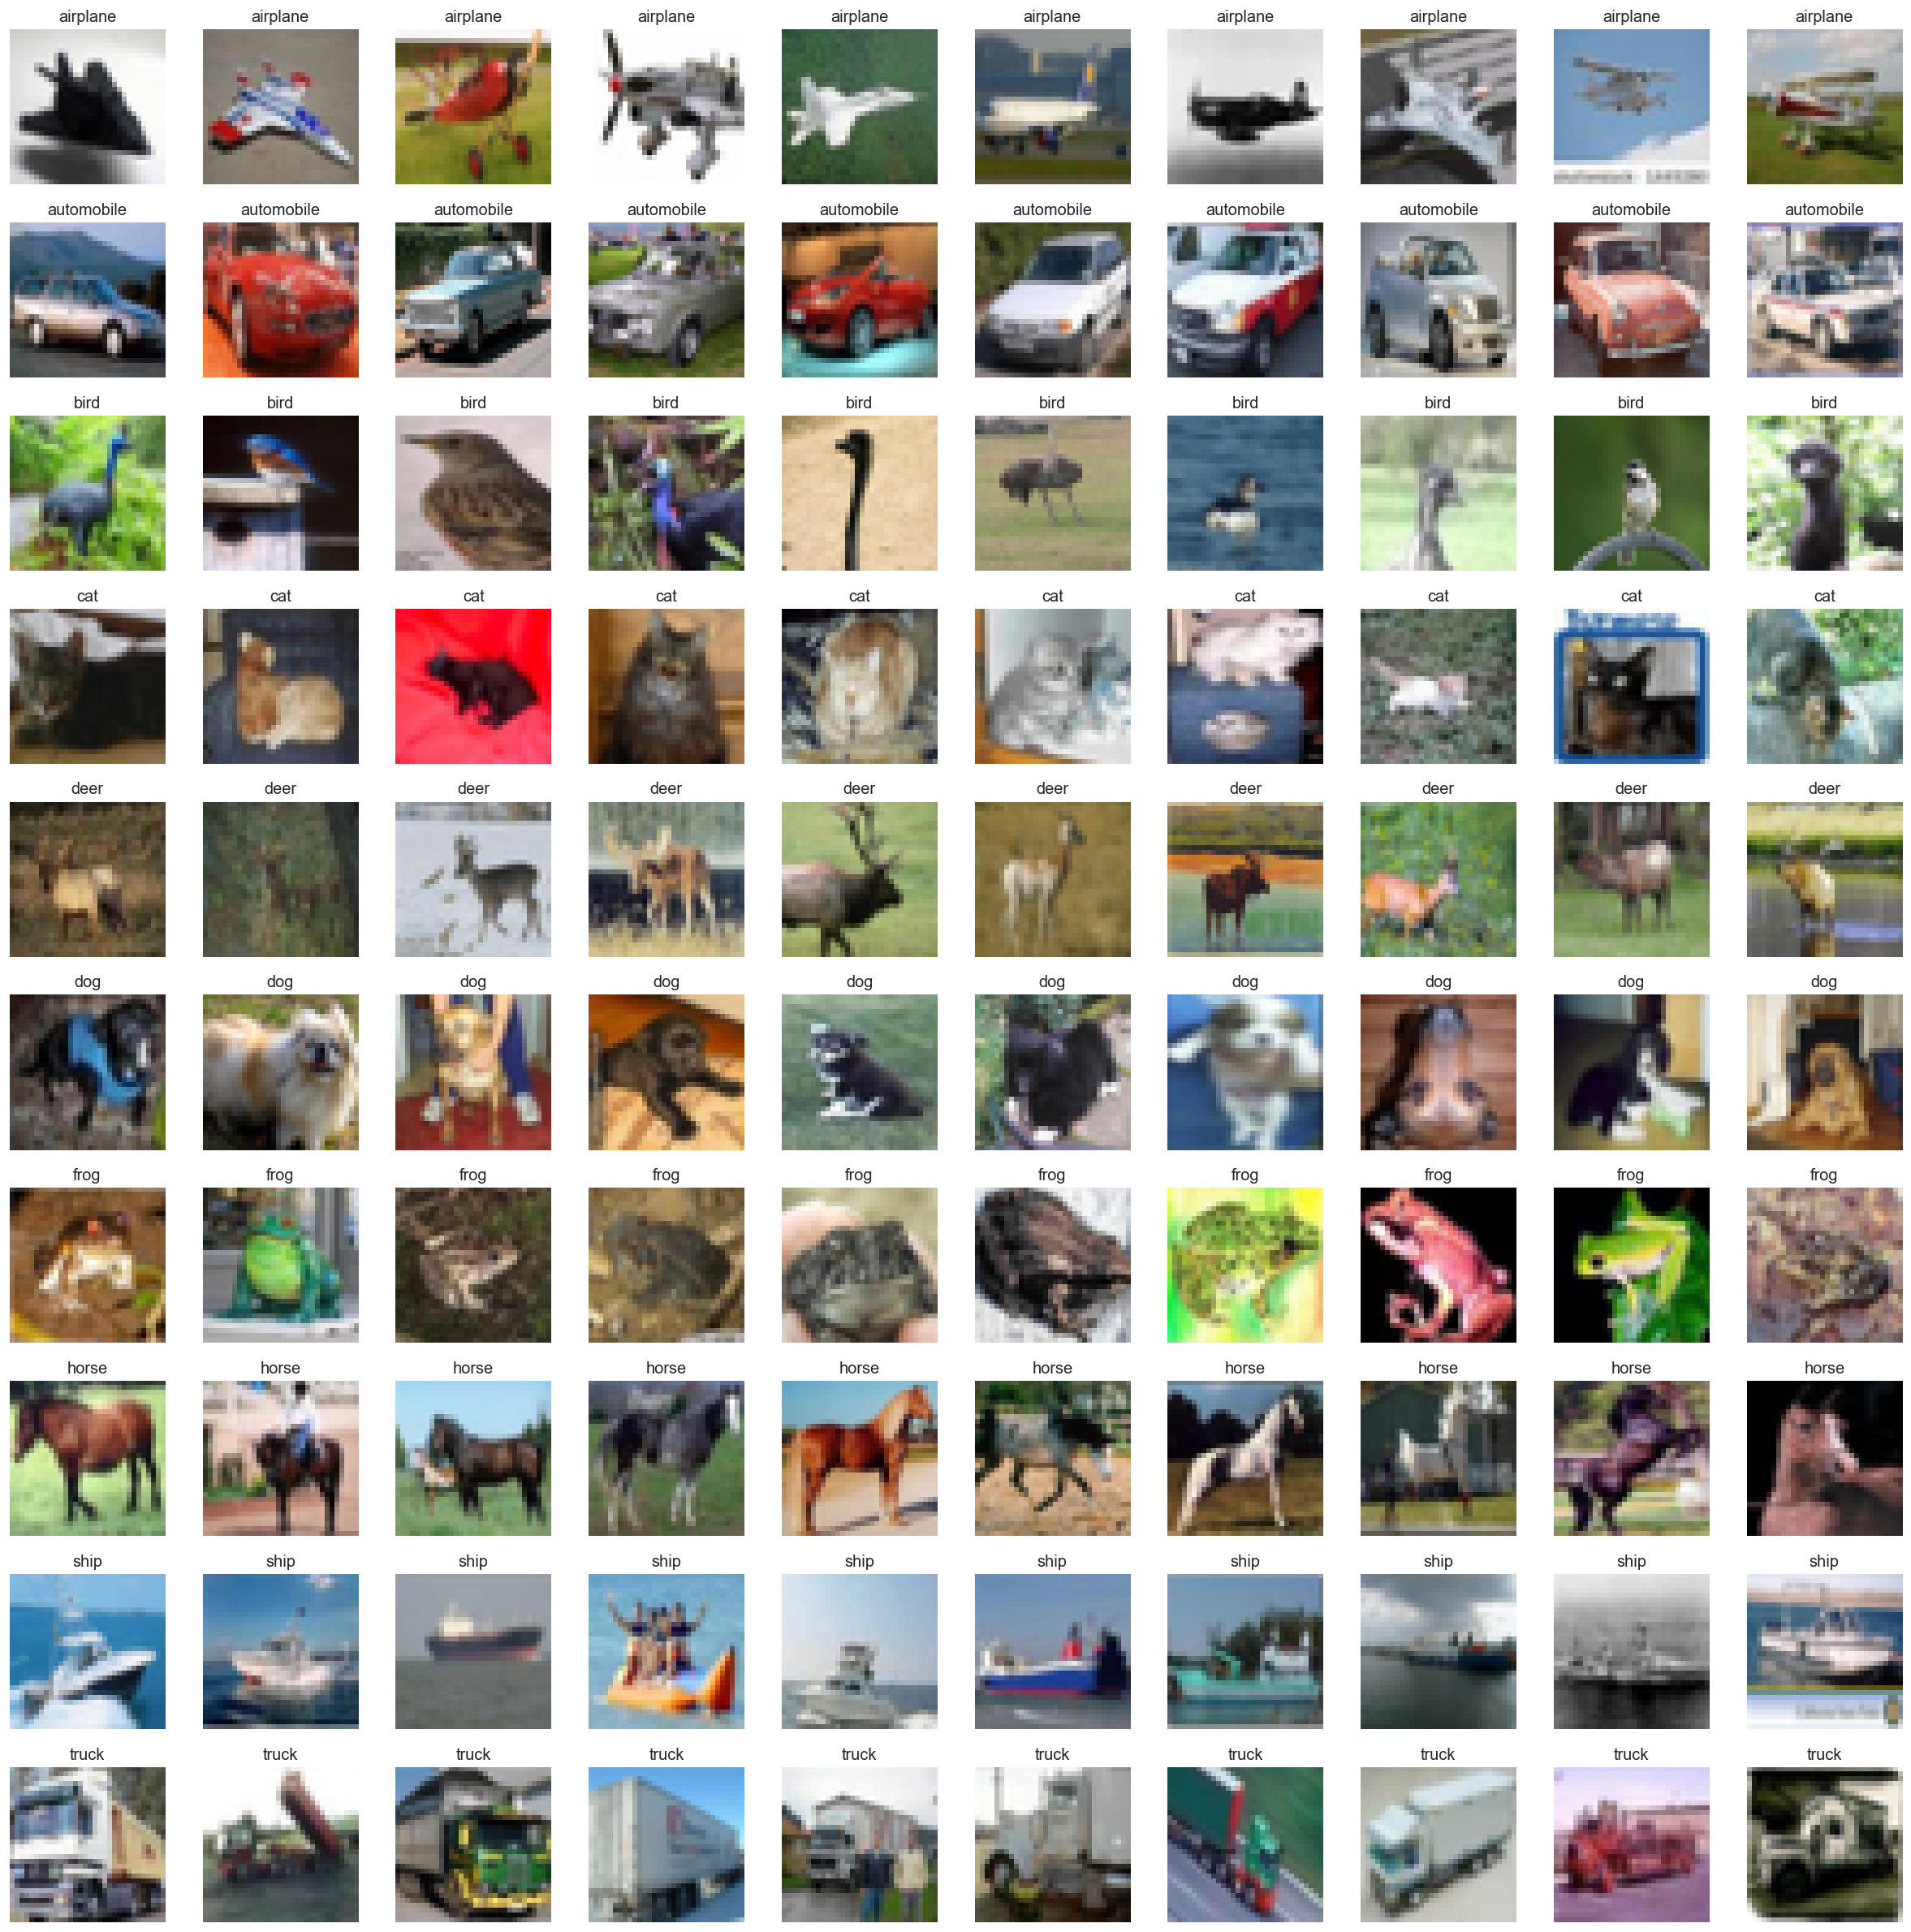

In [6]:
label_map = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

def display_images(images, labels, n_images=10):
    fig, axes = plt.subplots(nrows=n_labels, ncols=n_images, figsize=(20, 20))
    for i in range(n_images):
        for j in range(n_labels):
            axes[j, i].imshow(images[labels.flatten() == j][i])
            axes[j, i].set_title(label_map[j])
            axes[j, i].axis('off')
    plt.tight_layout()
    plt.show()

display_images(train_images, train_labels)

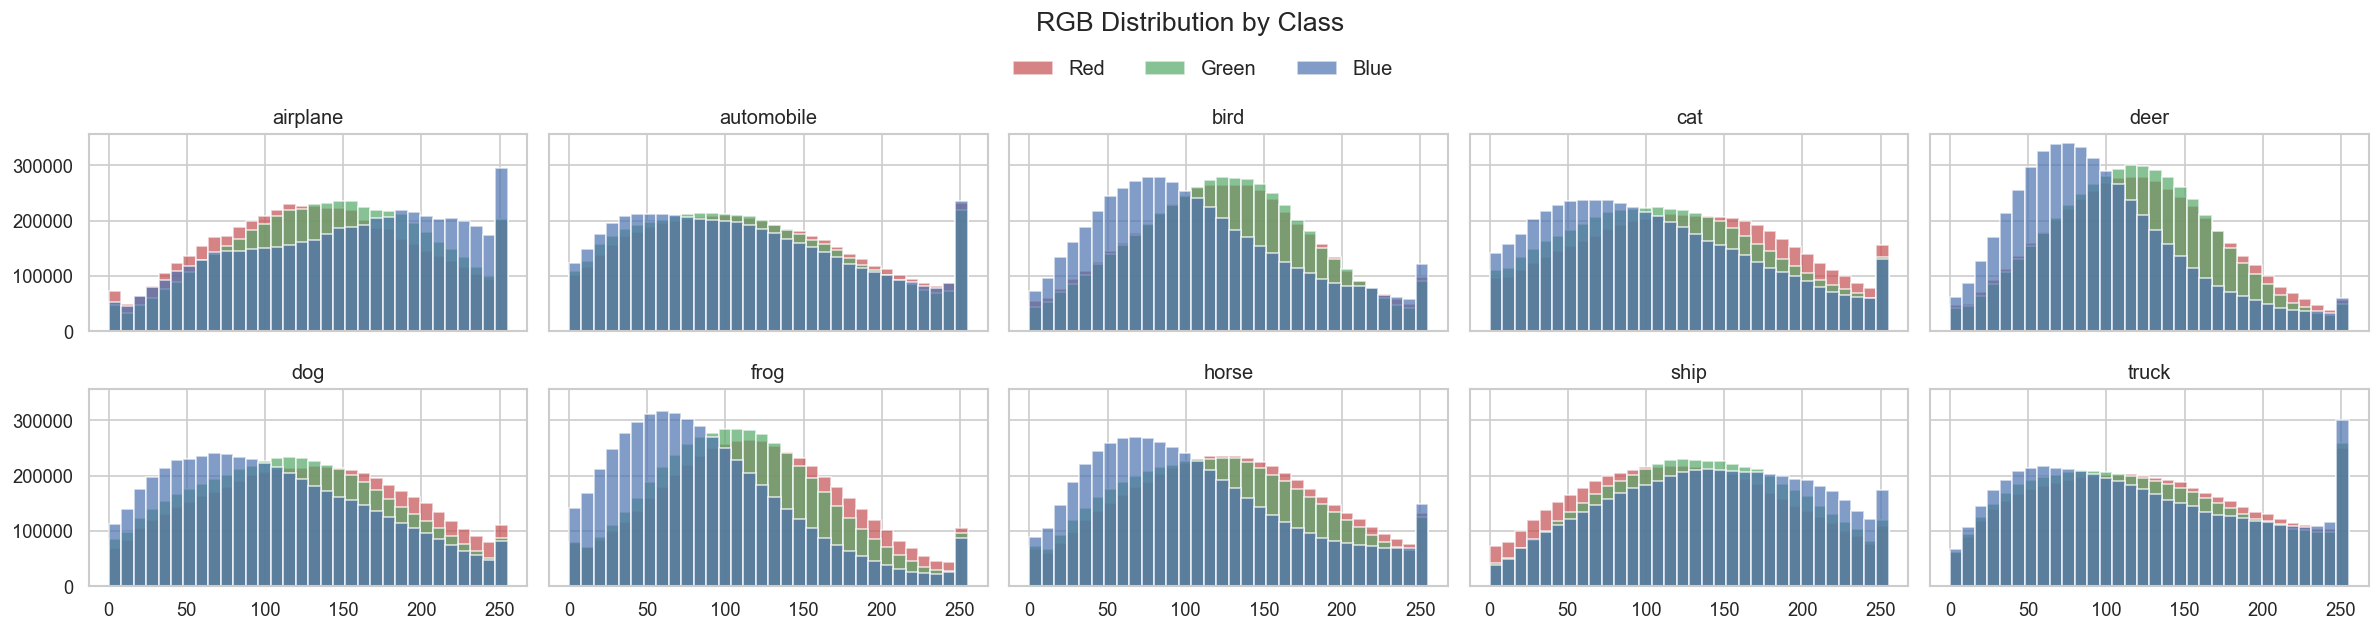

In [7]:
bins = 32

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 5), sharex=True, sharey=True)

for i, ax in zip(range(n_labels), axes.flat):
    idx = np.where(train_labels == i)[0]
    ax.hist(train_images[idx, ..., 0].ravel(), bins=bins, color='r', alpha=.7)
    ax.hist(train_images[idx, ..., 1].ravel(), bins=bins, color='g', alpha=.7)
    ax.hist(train_images[idx, ..., 2].ravel(), bins=bins, color='b', alpha=.7)
    ax.set_title(label_map[i])

fig.legend(['Red', 'Green', 'Blue'], loc='upper right', fontsize=12, ncol=3, bbox_to_anchor=(0.592, 1.0), frameon=False)
fig.suptitle('RGB Distribution by Class', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

## Data Preparation

In [8]:
images = tf.concat([train_images, test_images], axis=0)
labels = tf.concat([train_labels, test_labels], axis=0)

images = tf.cast(images, tf.float32)
labels = tf.cast(labels, tf.int32)

print(f'Images shape: {images.shape}')
print(f'Labels shape: {labels.shape}')

Images shape: (60000, 32, 32, 3)
Labels shape: (60000, 1)


In [86]:
# identify low contrast images
low_contrast_idx = []
for idx, img in enumerate(images):
    if exposure.is_low_contrast(img, fraction_threshold=35):
        low_contrast_idx.append(idx)
        print(f'Image {idx} is low contrast')

Image 420 is low contrast
Image 2610 is low contrast
Image 3049 is low contrast
Image 3259 is low contrast
Image 3418 is low contrast
Image 5296 is low contrast
Image 5957 is low contrast
Image 6406 is low contrast
Image 6452 is low contrast
Image 6826 is low contrast
Image 7089 is low contrast
Image 7452 is low contrast
Image 7654 is low contrast
Image 7662 is low contrast
Image 7811 is low contrast
Image 8072 is low contrast
Image 8100 is low contrast
Image 8246 is low contrast
Image 9130 is low contrast
Image 9395 is low contrast
Image 9592 is low contrast
Image 9858 is low contrast
Image 9881 is low contrast
Image 11650 is low contrast
Image 12129 is low contrast
Image 12166 is low contrast
Image 12469 is low contrast
Image 12507 is low contrast
Image 12672 is low contrast
Image 12802 is low contrast
Image 13340 is low contrast
Image 13955 is low contrast
Image 14708 is low contrast
Image 14899 is low contrast
Image 15596 is low contrast
Image 15911 is low contrast
Image 16254 is l

In [87]:
print(len(low_contrast_idx))

149


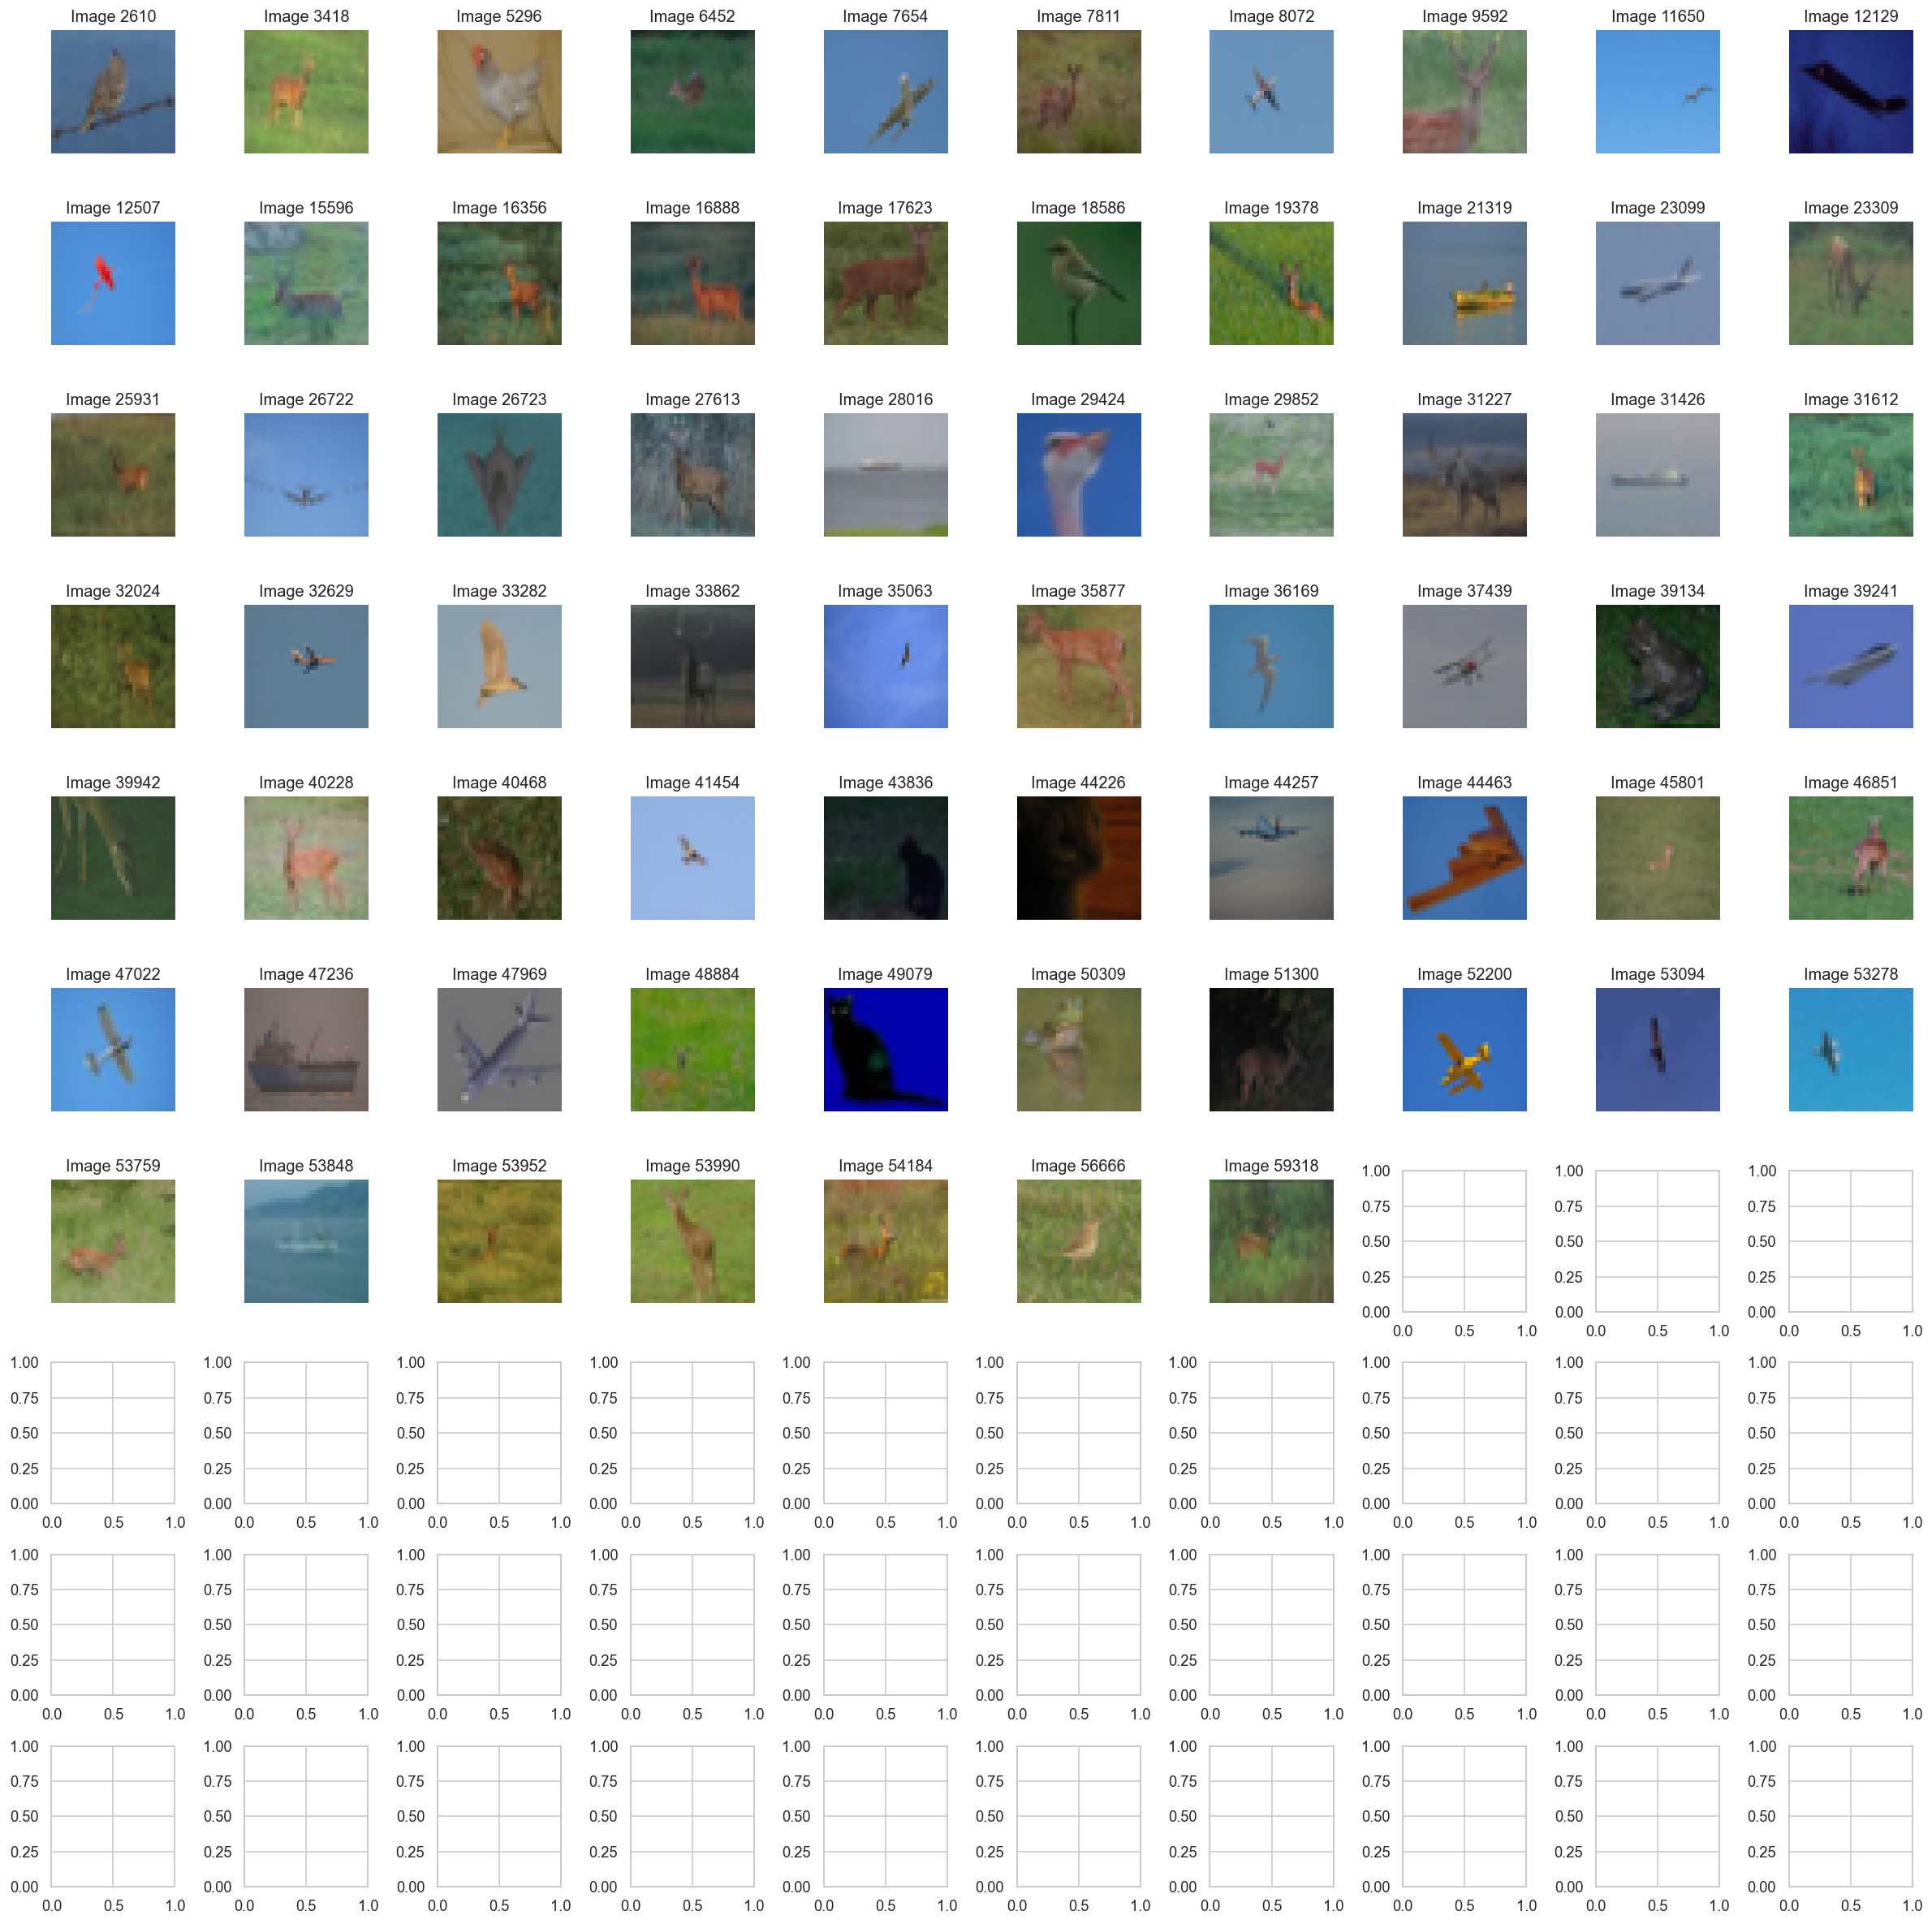

In [77]:
# visualize top 100 low contrast images
fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(20, 20))
ax = axes.flatten()

for i in range(len(low_contrast_idx)):
    ax[i].imshow(images[low_contrast_idx[i]].numpy().astype('uint8'))
    ax[i].set_title(f'Image {low_contrast_idx[i]}')
    ax[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# adjust contrast of images in low_contrast_idx


In [44]:
BUFFER_SIZE = 10_000
BATCH_SIZE = 128

dataset = Dataset.from_tensor_slices((images, labels))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.map(lambda x, y: ((x - 127.5) / 127.5, y))  # normalize images to range [-1, 1] as generator will be using tanh activation

print(dataset.element_spec, type(dataset))

(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.int32, name=None)) <class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>


In [ ]:
for batch in dataset.take(1):
    image, label = batch
    print(f'Image shape: {image.shape}')
    print(f'Label shape: {label.shape}')

Image shape: (128, 32, 32, 3)
Label shape: (128, 1)


## Export Dataset

In [ ]:
FILE_DIR = 'data/'
FILE_NAME = 'cifar10.tfrecords'

dataset.save(FILE_DIR + FILE_NAME)
print(f'Dataset saved to {FILE_DIR + FILE_NAME}')

Dataset saved to data/cifar10.tfrecords
